In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import L2
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.layers import concatenate

In [2]:
###load dataframes and do a bit of preprocessing of ttrain
ttrain=pd.read_pickle('./news_ttrain.pkl')
tvalid=pd.read_pickle('./news_tvalid.pkl')
test=pd.read_pickle('./news_test.pkl')
input_col='cleaned_words_withsw'
###Train a tokenizer and convert to integer sequences
tokenizer=Tokenizer()
train_list_str=ttrain[input_col].tolist()
tokenizer.fit_on_texts(train_list_str)
train_list = tokenizer.texts_to_sequences(train_list_str)
###compute number of distinct words, the max length of a sequence, and pad sequences to be equal length 
tlmax_len=max([len(tlist) for tlist in train_list])
tlnum_words=max([max(tlist) for tlist in train_list])
train_list = pad_sequences(train_list, maxlen=tlmax_len)

In [99]:
print(tlmax_len, tlnum_words)
train_list

249 53105


array([[   0,    0,    0, ...,  366,  424,   90],
       [   0,    0,    0, ...,   17,  289, 4355],
       [   0,    0,    0, ...,   48,    7, 4150],
       ...,
       [   0,    0,    0, ..., 2844,    6,    4],
       [   0,    0,    0, ...,   82,   16,  297],
       [   0,    0,    0, ...,  816, 5376,  205]], dtype=int32)

In [48]:
###now we preprocess the validation set
valid_list_str=tvalid[input_col].tolist()
valid_list = tokenizer.texts_to_sequences(valid_list_str)
###need to truncate any strings that are too long, then pad to appropriate length
valid_list = [tlist[0:tlmax_len] for tlist in valid_list]
valid_list = pad_sequences(valid_list, maxlen=tlmax_len)

###Same treatment for test set
test_list_str=test[input_col].tolist()
test_list = tokenizer.texts_to_sequences(test_list_str)
test_list = [tlist[0:tlmax_len] for tlist in test_list]
test_list = pad_sequences(test_list, maxlen=tlmax_len)

In [49]:
print(train_list.shape)
print(valid_list.shape)
print(test_list.shape)

(83720, 154)
(20931, 154)
(26163, 154)


In [50]:
###Now we make one hot encoded y vectors for the train and validation sets
ytrain= pd.get_dummies(ttrain['category_col']).to_numpy()
yvalid= pd.get_dummies(tvalid['category_col']).to_numpy()
ytest= pd.get_dummies(test['category_col']).to_numpy()
print(ytrain.shape, yvalid.shape, ytest.shape)
ytrain

(83720, 12) (20931, 12) (26163, 12)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [51]:
###Some model hyperparameters, chosen by training different models over a set of options
embed_len=256
reg_param=0 ### in testing, even small regularization worsened accuracy
lr=0.0002 ###smaller than default learning rate leads to more stable outcomes, albeit longer train times
nfeatures=256

input = Input(shape=tlmax_len)
x = input
x=Embedding(tlnum_words+1, embed_len, input_length=tlmax_len, mask_zero=True)(x)

###Model creates 3 filters over kernels of size 2, 4, and 6. kernel arrangement chosen as the best from a list of tested options
tower_1 = Conv1D(nfeatures, 2, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_1 = GlobalMaxPooling1D() (tower_1)
tower_2 = Conv1D(nfeatures, 4, padding='valid', activation='relu',kernel_regularizer=L2(reg_param))(x)
tower_2 = GlobalMaxPooling1D() (tower_2)
tower_3 = Conv1D(nfeatures, 6, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_3 = GlobalMaxPooling1D() (tower_3)

###Merge the output of the 3 filters, flatten, then combine their output with a dense sigmoid layer with dropout
merged = concatenate([tower_1, tower_2, tower_3], axis=1)
merged = Flatten()(merged)
merged = Dropout(0.3)(merged)
output=Dense(12, activation='softmax', kernel_regularizer=L1(reg_param))(merged)
model=Model(inputs=input, outputs=output)
###Compile model with custom choice of learning rate and binary crossentropy loss
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])


In [52]:
out = model.fit(train_list, ytrain, validation_data=(valid_list, yvalid), epochs=3, callbacks=[es])

Epoch 1/3
2617/2617 [==============================] - 1441s 550ms/step - loss: 0.1661 - accuracy: 0.6122 - val_loss: 0.1069 - val_accuracy: 0.7673
Epoch 2/3
2617/2617 [==============================] - 1443s 551ms/step - loss: 0.0888 - accuracy: 0.8159 - val_loss: 0.0892 - val_accuracy: 0.8114
Epoch 3/3
2617/2617 [==============================] - 1438s 549ms/step - loss: 0.0660 - accuracy: 0.8701 - val_loss: 0.0875 - val_accuracy: 0.8186


In [53]:
###Generate prediction vector on the validation set 
categories = ['BLACK VOICES', 'BUSINESS', 'ENTERTAINMENT', 'FOOD & DRINK', 'PARENTING', 'POLITICS', 'QUEER VOICES', 'SPORTS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS', 'WORLD NEWS'] 
y_pred=model.predict(test_list).tolist()
ypred1=[]
ypred2=[]
for tlist in y_pred:
    tmax=max(tlist)
    temp=[1 if i==tmax else 0 for i in tlist]
    for i, j in enumerate(temp):
        if j==1:
            ypred2.append(categories[i])
    ypred1.append(temp)
accuracy_score(ypred1, ytest)


0.8186370064595039

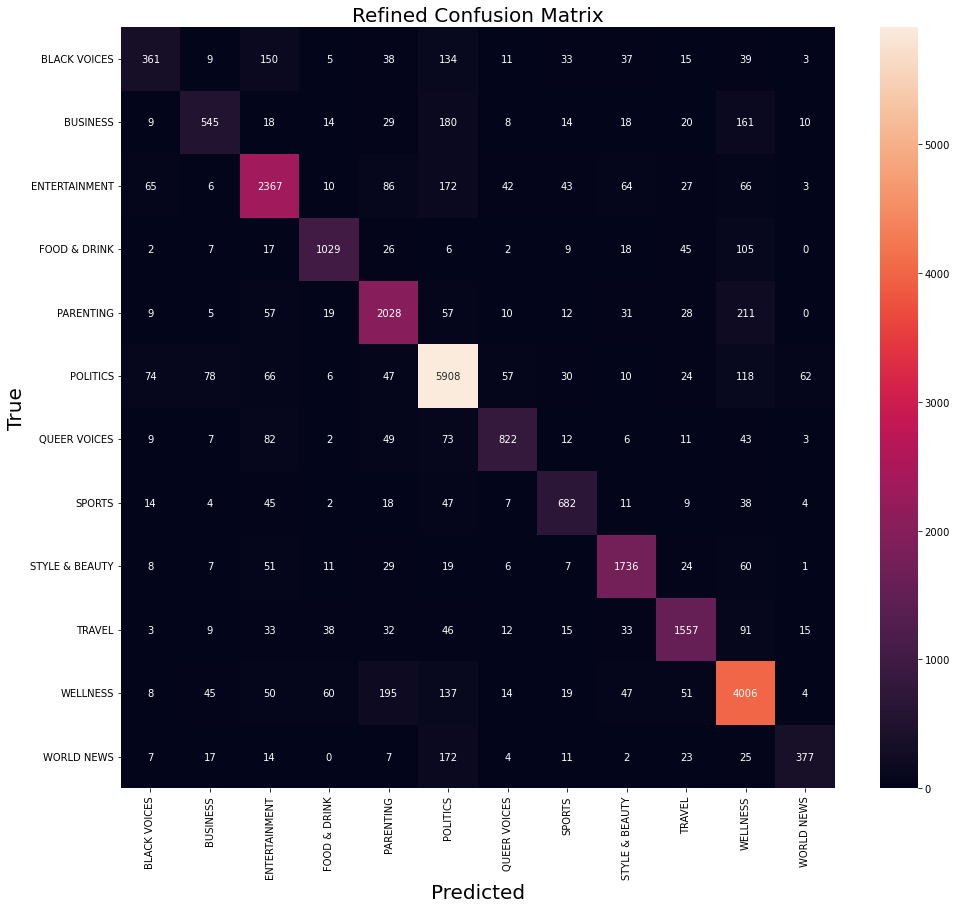

In [54]:
cm = confusion_matrix(test['category_col'].to_list(), ypred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
labels = categories
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)
plt.show()

In [56]:
print(classification_report(ytest, ypred1,target_names=categories))

                precision    recall  f1-score   support

  BLACK VOICES       0.63      0.43      0.51       835
      BUSINESS       0.74      0.53      0.62      1026
 ENTERTAINMENT       0.80      0.80      0.80      2951
  FOOD & DRINK       0.86      0.81      0.84      1266
     PARENTING       0.78      0.82      0.80      2467
      POLITICS       0.85      0.91      0.88      6480
  QUEER VOICES       0.83      0.73      0.78      1119
        SPORTS       0.77      0.77      0.77       881
STYLE & BEAUTY       0.86      0.89      0.87      1959
        TRAVEL       0.85      0.83      0.84      1884
      WELLNESS       0.81      0.86      0.83      4636
    WORLD NEWS       0.78      0.57      0.66       659

     micro avg       0.82      0.82      0.82     26163
     macro avg       0.80      0.75      0.77     26163
  weighted avg       0.82      0.82      0.81     26163
   samples avg       0.82      0.82      0.82     26163



In [66]:
###save model predictions to the dataset for later analysis
test['cnn_cat_pred']= ypred2
test.to_pickle('./news_test_with_pred.pkl')

In [69]:
###some rows corresponding to failed model predictions are displayed here (I find them interesting)
pd.set_option('display.max_colwidth', None)
test[test['category_col']!=test['cnn_cat_pred']][['headline_col', 'short_description', 'cleaned_words', 'category_col', 'cnn_cat_pred']].head(50) 

,headline_col,short_description,cleaned_words,category_col,cnn_cat_pred
2,Coast To Coast: Kids' Classes That Rock,From aerial arts to bouldering to chess club... Read more on Daily Candy,coast coast kid class rock aerial art bouldering chess club ... read daily candy,PARENTING,TRAVEL
11,The Best Nanobreweries in the Country,Today's nanobrewery could easily be tomorrow's next big thing. Here are 10 of our favorite nanobreweries across the nation.,best nanobreweries country today nanobrewery could easily tomorrow next big thing 10 favorite nanobreweries across nation,FOOD & DRINK,WELLNESS
15,Hawaii Developer Under Fire For Segregated 'Poor Door' For Renters,The controversial entrance has been proposed across the country.,hawaii developer fire segregated 'poor door renter controversial entrance propose across country,BUSINESS,POLITICS
25,Mary Ellen Vernon Loves Boulder,"Always drawn to the water and the coast, I found myself surprisingly at ease in the tranquility of the mountains and trees.",mary ellen vernon love boulder always draw water coast find surprisingly ease tranquility mountain tree,TRAVEL,ENTERTAINMENT
27,The Big Moves This Past Year In The Fight Against the World's Top Infectious Killer,Global health experts see an uptick in political will in the fight against tuberculosis.,big move past year fight world top infectious killer global health expert see uptick political fight tuberculosis,POLITICS,WELLNESS
32,Dear Lululemon: I Am a Plus-Size Woman Who Has Never Ripped a Pair of Pants,"I thought about how unfair women's sizes are to men's sizes. I do not wear anything that is considered a large. No one makes comments about my size anymore. I have not ripped or gone through a pair of pants in years. Yet if I was a women I would have to shop at ""plus-size"" stores.",dear lululemon plus size woman never rip pair pant think unfair woman size men size wear anything consider large one make comment size anymore rip go pair pant year yet woman would shop `` plus size '' store,WELLNESS,STYLE & BEAUTY
35,Steelers Linebacker Hurt In Head-On Tackle Stands For Pittsburgh Crowd,"Ryan Shazier, who couldn't move his legs after a severe spinal injury in December, saluted fans at a Penguins game.",steelers linebacker hurt head tackle stand pittsburgh crowd ryan shazier could n't move leg severe spinal injury december salute fan penguin game,SPORTS,WELLNESS
41,Marcus Garvey's Message And Why A Pardon For Him Matters,"Proverbs 29:18 says “where there is no vision, a people perish.” The U.S. Government’s long campaign to discredit civil rights",marcus garvey message pardon matter proverb 29:18 say “ vision people perish. ” u.s. government long campaign discredit civil right,BLACK VOICES,POLITICS
52,Reminder: The Right-Wing Owes Us $25 Billion,"With the havoc that could be wreaked by the Zika virus, the right-wing feel they must ""find"" money in the budget to offset the research and development necessary to be ready for it. But, $25 billion to shut down the government? Not a problem.",reminder right wing owe u 25 billion havoc could wreak zika virus right wing feel must `` find '' money budget offset research development necessary ready 25 billion shut government problem,POLITICS,WELLNESS
57,Art For Life Gala 2013: Russell Simmons' Star-Studded Event Raises Money For At-Risk Youth (PHOTOS),"Amazing, right? Head over to the Rush Philanthropic Arts Foundation website to learn more about the organization and how",art life gala 2013 russell simmons star stud event raise money risk youth photo amaze right head rush philanthropic art foundation website learn organization,BLACK VOICES,STYLE & BEAUTY
